In [2]:
import torch
import torch.nn as nn

# 图像卷积

## 互相关运算
根据上一节的推导, 其实卷积层的运算并不是严格的卷积运算(这里我感觉可以通过旋转卷积核的方式转换为输入和另外一个矩阵的卷积), 但是感觉这里的互运算很容易理解

假设忽略通道(第三维), 那么对于两维数组, 互相关运算过程如下:
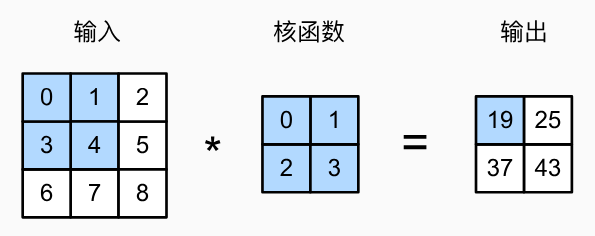
此时具体的运算关系如下:
$$
\begin{align*}
0 \times 0 + 1 \times 1 + 3 \times 2 + 4 \times 3 &= 19, \\
1 \times 0 + 2 \times 1 + 4 \times 2 + 5 \times 3 &= 25, \\
3 \times 0 + 4 \times 1 + 6 \times 2 + 7 \times 3 &= 37, \\
4 \times 0 + 5 \times 1 + 7 \times 2 + 8 \times 3 &= 43.
\end{align*}
$$
假设输入大小为 $n_h \times n_w$, 卷积核大小为 $k_h \times k_w$, 那么输出的大小为(画图理解即可):
$$
(n_h - k_h + 1) \times (n_w - k_w + 1)
$$

In [3]:
# 卷积实现
def cov(X, K):
    h, w = X.shape[0], X.shape[1]
    m, n = K.shape[0], K.shape[1]
    Y = torch.zeros(h - m + 1, w - n + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+m, j:j+n]*K).sum()
    return Y

In [4]:
X = torch.arange(9).reshape((3, 3))
K = torch.arange(4).reshape((2, 2))
Y = cov(X, K)
Y

tensor([[19., 25.],
        [37., 43.]])

## 卷积层
卷积层对输入和卷积核权重进行互相关运算, 并且添加标量偏置之后产生输出, 所以被训练参数为卷积核权重和标量偏置, 可以利用上面定义的函数来实现卷积层

In [5]:
# 实现卷积层 二维
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, X):
        return cov(X, self.weight) + self.bias

In [6]:
net = Conv2D((2, 2))
# 注意网络参数初始化方式, 要么使用 nn.init 中的函数
# 要么直接 net.element.data = 直接初始化
net.weight.data = K.type(torch.float32)
nn.init.constant_(net.bias, 1)
Y = net(X)
Y

tensor([[20., 26.],
        [38., 44.]], grad_fn=<AddBackward0>)

## 图像中目标的边缘检测
比如对于一个大小为 $6 \times 8$大小的黑白图像, 需要检测图像的边界

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [8]:
K = torch.tensor([[1.0, -1.0]])
Y = cov(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

这里的原理就是通过互相关操作, 相邻的位置如果像素相同, 那么得到 `0`, 如果像素不同, 那么就会得到 `-1`

## 学习卷积核
主要是学习到卷积核的权重等参数

In [11]:
# 构造卷积层, 1输出通道以及形状为(1,2)的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False) # 注意这里的 kernel_size 设置
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2
for i in range(10):
    Y_hat = conv2d(X)
    loss = (Y_hat - Y)**2
    conv2d.zero_grad()
    loss.sum().backward()
    conv2d.weight.data[:] -= lr*conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {loss.sum():.3f}')

epoch 2, loss 6.634
epoch 4, loss 2.210
epoch 6, loss 0.820
epoch 8, loss 0.322
epoch 10, loss 0.129


In [12]:
conv2d.weight.data.reshape((1, 2)) # 这里可以得到对应的卷积核

tensor([[ 1.0294, -0.9556]])

## 互相关和卷积
还是上面提到的, 互相关运算和卷积运算其实几乎可以等价, 把互相关运算中的卷积核在水平和垂直方向上翻转(旋转 180 度), 就可以得到卷积运算中的卷积核

## 特征映射和感受野
输出的卷积层可以叫特征映射,也可以视为一个输入映射到下一层的空间维度的转换器, 在卷积神经网络中, 对于某一层的任意元素 $x$, 感受野就是前向传播过程中可能影响 $x$ 计算的所有元素, 比如对于上面提到的隐藏层 $\mathbf{Y}$ 中的第一个元素, 它的感受野就是输入 $\mathbf{X}$ 中对应为是的四个元素, 如果通过一定的运算, 最终得到单个元素 $z$, 那么 $z$ 的感受野就是 $\mathbf{Y}$ 中的四个元素以及 $\mathbf{X}$ 中的所有元素